In [1]:

import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras.wrappers.scikit_learn import KerasClassifier
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from xml.sax import ContentHandler, parse
from zipfile import ZipFile

stemmer = SnowballStemmer('english', ignore_stopwords=True)
stop = set(stopwords.words('english'))

%matplotlib inline
sns.set(rc={'figure.figsize': (11.7, 8.27)})

warnings.filterwarnings("ignore")


In [2]:
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification


In [3]:
model_path = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizerFast.from_pretrained(model_path)
model = DistilBertForSequenceClassification.from_pretrained(
    model_path, id2label={0: "NEG", 1: "POS"}, label2id={"NEG": 0, "POS": 1})


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'pre_classi

In [4]:

class ExcelHandler(ContentHandler):

    def __init__(self):
        self.chars = []
        self.cells = []
        self.rows = []
        self.tables = []

    def characters(self, content):
        self.chars.append(content)

    def startElement(self, name, atts):

        if name == "Cell":
            self.chars = []

        elif name == "Row":
            self.cells = []

        elif name == "Table":
            self.rows = []

    def endElement(self, name):

        if name == "Cell":
            self.cells.append(''.join(self.chars))

        elif name == "Row":
            self.rows.append(self.cells)

        elif name == "Table":
            self.tables.append(self.rows)


excelHandler = ExcelHandler()
parse('./features.xls', excelHandler)
features = pd.DataFrame(
    excelHandler.tables[0][1:], columns=excelHandler.tables[0][0])


In [5]:
features.head()


,TextID,URL,Label,totalWordsCount,semanticobjscore,semanticsubjscore,CC,CD,DT,EX,...,pronouns2nd,pronouns3rd,compsupadjadv,past,imperative,present3rd,present1st2nd,sentence1st,sentencelast,txtcomplexity
0,Text0001,http://msn.foxsports.com/foxsoccer/mexico/stor...,objective,109,0,1,7,9,0,5,...,0,3,0,11,0,0,0,0,1,18
1,Text0002,http://msn.foxsports.com/foxsoccer/premierleag...,objective,309,21,4,1,19,1,4,...,0,10,0,13,0,14,9,1,1,14
2,Text0003,http://uk.eurosport.yahoo.com/04022011/58/fed-...,objective,149,6,1,8,14,0,5,...,0,2,0,8,0,3,2,1,1,18
3,Text0004,http://uk.eurosport.yahoo.com/07022011/58/bund...,objective,305,18,5,7,26,0,10,...,0,8,3,13,1,7,1,1,1,20
4,Text0005,http://uk.eurosport.yahoo.com/05022011/58/fed-...,objective,491,23,8,33,47,0,12,...,0,16,2,34,1,5,6,1,1,24


In [6]:


# objective = 0, subjective = 1
y = np.where(features['Label'] == 'objective', 0, 1)

texts = []

preprocessed_texts = []

for i in range(1, 1001):

    if i // 10 == 0:

        number = '000' + str(i)

    elif i // 100 == 0:

        number = '00' + str(i)

    elif i // 1000 == 0:

        number = '0' + str(i)

    else:
        number = '1000'

    f = open('./Text' +
             number + '.txt', 'r', encoding='latin-1')

    text = f.read()

    preprocessed_text = ' '.join([stemmer.stem(w) for w in word_tokenize(
        text) if (w.isalpha() and w not in stop)])

    texts.append(text)

    preprocessed_texts.append(preprocessed_text)


In [7]:

data = pd.DataFrame({'texts': np.array(
    texts), 'preprocessed_texts': np.array(preprocessed_texts), 'label': y})


objective_texts = ' '.join(
    data[data['label'] == 0]['preprocessed_texts'].tolist())


subjective_texts = ' '.join(
    data[data['label'] == 1]['preprocessed_texts'].tolist())


In [8]:

X = np.array(preprocessed_texts)


In [9]:
X


array(['finalist apertura toluca drawn first two clausura game got good start edgar benitez put ahead minut matia brito level minut later luca silva net minut end ensur visitor took three point franco arizala score minut time ensur jaguar claim first point draw monterrey open score aldo de nigri host jaguar also jorg rodriguez sent close moment',
       'citi manag roberto mancini consist said fellow italian sale throughout month transfer window quash rumor link san siro giant milan made like clear previous baulk citi report valuat now fresh report emerg claim negoti club begun citi public messag matter chang coach david platt said i saw specul sunday i heard anyth as far concern i think still manchest citi player i think anyth go happen platt speak mancini behalf press confer preview citi barclay premier leagu trip qpr tuesday night mancini equal forthright balotelli subject ask last met press last week mancini said no true mario stay we request mario player balotelli involv number co

In [10]:
# vocab extraction

def build_vocab(texts):

    sentences = texts.apply(lambda x: x.split()).values
    vocab = {}

    for sentence in sentences:

        for word in sentence:

            try:
                vocab[word] += 1

            except KeyError:

                vocab[word] = 1

    return vocab


In [11]:
# this is the text data
X_train, X_test, y_train_raw, y_test_raw = train_test_split(
    np.array(preprocessed_texts), y, random_state=13, stratify=y)


In [12]:

print(X_train.shape, y_train_raw.shape)

print(X_test.shape, y_test_raw.shape)


(750,) (750,)
(250,) (250,)


In [13]:
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences


# we padd the text here


embed_size = 50  # how big is each word vector
# how many unique words to use (i.e num rows in embedding vector)
max_features = 10000
maxlen = 200  # max number of words in text to use

tokenizer = Tokenizer(num_words=max_features)

tokenizer.fit_on_texts(X_train)

tokenized_train = tokenizer.texts_to_sequences(X_train)
tokenized_test = tokenizer.texts_to_sequences(X_test)

Padded_X_train = pad_sequences(tokenized_train, maxlen=maxlen)
Padded_X_test = pad_sequences(tokenized_test, maxlen=maxlen)


In [14]:

print(Padded_X_train.shape, y_train_raw.shape)
print(Padded_X_test.shape, y_test_raw.shape)


(750, 200) (750,)
(250, 200) (250,)


### Embedding Method with the Gloves


In [15]:

embedding_dictionary = dict()
embedding_dim = 100

with open('./glove.6B.100d.txt', encoding="utf8")as fp:
    for line in fp.readlines():
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype='float32')
        embedding_dictionary[word] = vector_dimensions


In [16]:
vocab_length = len(tokenizer.word_index) + 1
vocab_length


14595

In [17]:
embedding_matrix = np.zeros((vocab_length, embedding_dim))

for word, index in tokenizer.word_index.items():
    embedding_vector = embedding_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector


In [18]:
embedding_matrix


array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.046539  ,  0.61966002,  0.56647003, ..., -0.37616   ,
        -0.032502  ,  0.80620003],
       [-0.038194  , -0.24487001,  0.72812003, ..., -0.1459    ,
         0.82779998,  0.27061999],
       ...,
       [-0.25994   ,  0.26782   , -0.72845   , ...,  0.17399999,
        -0.71634001,  0.079196  ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

## Classification with BiLSTM


In [19]:
vocab_size = len(tokenizer.word_index)+1


In [20]:
from keras.models import Sequential

model = Sequential()
model.add(Embedding(vocab_size, 100, weights=[
          embedding_matrix], input_length=200, trainable=False))

model.add(Bidirectional(LSTM(32)))

model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='relu'))
model.add(Dropout(0.5))


model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy',
              metrics=['accuracy'])


In [21]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 100)          1459500   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               34048     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                        

In [22]:
model.compile("adam", "binary_crossentropy", metrics=["accuracy"])
history = model.fit(Padded_X_train, y_train_raw, batch_size=10, epochs=15)


Epoch 1/15
75/75 [==============================] - 8s 55ms/step - loss: 0.6943 - accuracy: 0.6240
Epoch 2/15
75/75 [==============================] - 4s 57ms/step - loss: 0.6843 - accuracy: 0.6320
Epoch 3/15
75/75 [==============================] - 4s 57ms/step - loss: 0.6798 - accuracy: 0.6320
Epoch 4/15
75/75 [==============================] - 4s 49ms/step - loss: 0.6741 - accuracy: 0.6400
Epoch 5/15
75/75 [==============================] - 4s 50ms/step - loss: 0.6706 - accuracy: 0.6387
Epoch 6/15
75/75 [==============================] - 4s 52ms/step - loss: 0.6665 - accuracy: 0.6427
Epoch 7/15
75/75 [==============================] - 4s 49ms/step - loss: 0.6614 - accuracy: 0.6520
Epoch 8/15
75/75 [==============================] - 4s 50ms/step - loss: 0.6538 - accuracy: 0.6600
Epoch 9/15
75/75 [==============================] - 4s 56ms/step - loss: 0.6411 - accuracy: 0.6733
Epoch 10/15
75/75 [==============================] - 4s 58ms/step - loss: 0.6480 - accuracy: 0.6640
Epoch 11/

In [23]:
values = history.history


In [24]:
print(history.history.keys())


dict_keys(['loss', 'accuracy'])


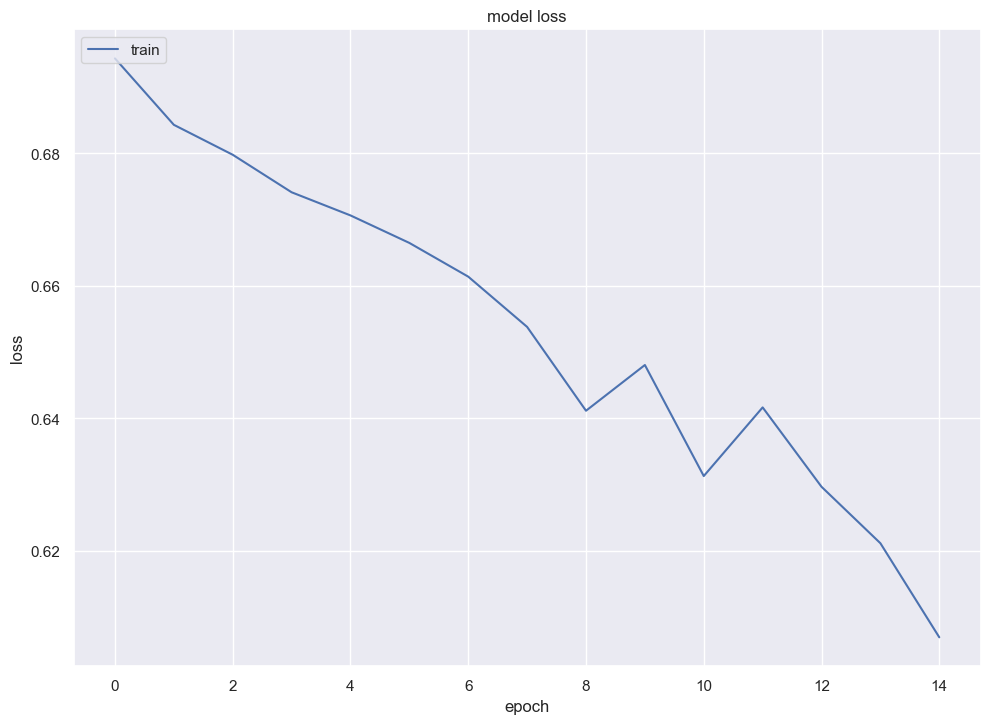

In [25]:

# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


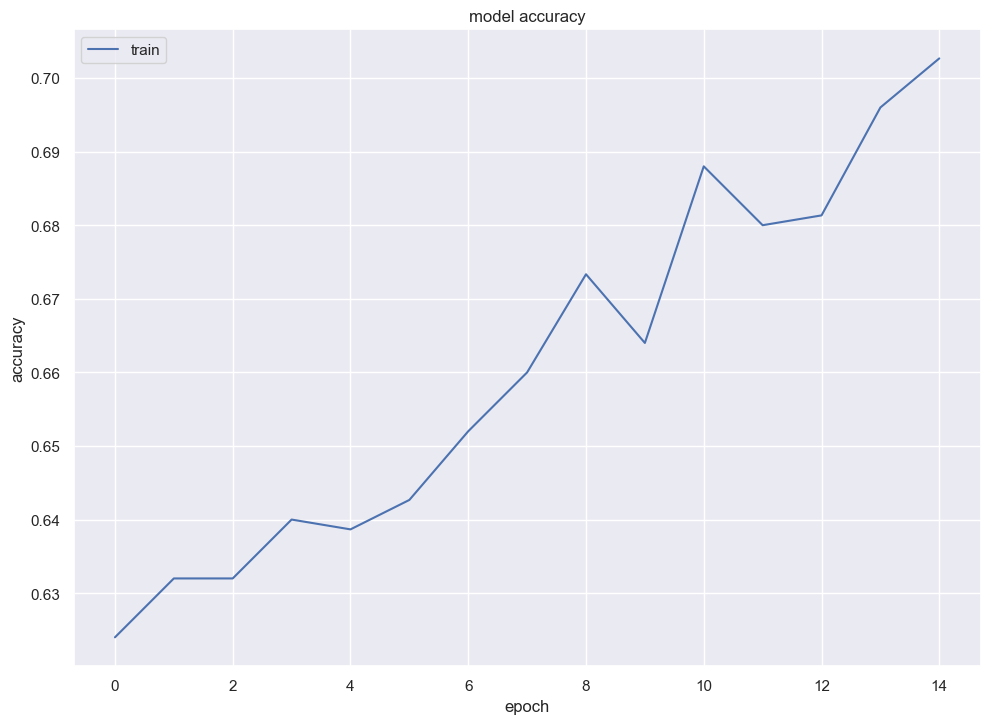

In [26]:

# summarize history for loss
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#### The transfomer model


In [29]:
# from tensorflow.keras.models import Model
# from tensorflow.keras.callbacks import ModelCheckpoint

import transformers
from tqdm.notebook import tqdm
from tokenizers import BertWordPieceTokenizer
from transformers import BertTokenizer


from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')


def bert_encode(data, maximum_length):
    input_ids = []
    attention_masks = []

    for text in X:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=maximum_length,
            pad_to_max_length=True,
            return_attention_mask=True,
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])

    return np.array(input_ids), np.array(attention_masks)


In [30]:
train_input_ids, train_attention_masks = bert_encode(X, 60)


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


### The BERT Model


In [31]:
import tensorflow as tf
from keras.optimizers import Adam


def build_bert_model(bert_layer):

    input_ids = tf.keras.Input(shape=(60,), dtype='int32')

    attention_masks = tf.keras.Input(shape=(60, ), dtype='int32')

    output = build_bert_model([input_ids, attention_masks])
    output = output[1]
    output = tf.keras.layers.Dense(32, activation='relu')(output)
    output = tf.keras.layers.Dropout(0.2)(output)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(output)

    model = tf.keras.models.Model(
        inputs=[input_ids, attention_masks], outputs=output)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model


In [32]:

from transformers import BertTokenizer, TFBertModel, BertModel
bert_model = TFBertModel.from_pretrained('bert-base-uncased')


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [33]:
model = build_bert_model(bert_model)
model.summary()


: 

: 

### Transformer Similarity Measurments


### KNeighborsClassifier


In [30]:
from sklearn.neighbors import KNeighborsClassifier
params = {'n_neighbors': [11, 13, 15, 17]}
neighbors = KNeighborsClassifier()
clf = GridSearchCV(neighbors, params, verbose=3)
clf.fit(Padded_X_train, y_train_raw)


Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END ....................n_neighbors=11;, score=0.687 total time=   0.0s
[CV 2/5] END ....................n_neighbors=11;, score=0.647 total time=   0.0s
[CV 3/5] END ....................n_neighbors=11;, score=0.653 total time=   0.0s
[CV 4/5] END ....................n_neighbors=11;, score=0.627 total time=   0.0s
[CV 5/5] END ....................n_neighbors=11;, score=0.580 total time=   0.0s
[CV 1/5] END ....................n_neighbors=13;, score=0.653 total time=   0.0s
[CV 2/5] END ....................n_neighbors=13;, score=0.653 total time=   0.0s
[CV 3/5] END ....................n_neighbors=13;, score=0.667 total time=   0.0s
[CV 4/5] END ....................n_neighbors=13;, score=0.613 total time=   0.0s
[CV 5/5] END ....................n_neighbors=13;, score=0.607 total time=   0.0s
[CV 1/5] END ....................n_neighbors=15;, score=0.653 total time=   0.0s
[CV 2/5] END ....................n_neighbors=15;,

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [11, 13, 15, 17]}, verbose=3)

In [31]:
print(y_test_raw.shape)


(250,)


In [32]:

neighbors = KNeighborsClassifier(**clf.best_params_)
neighbors.fit(Padded_X_train, y_train_raw)
print(clf.best_params_)
y_pred = neighbors.predict(Padded_X_test)


{'n_neighbors': 17}


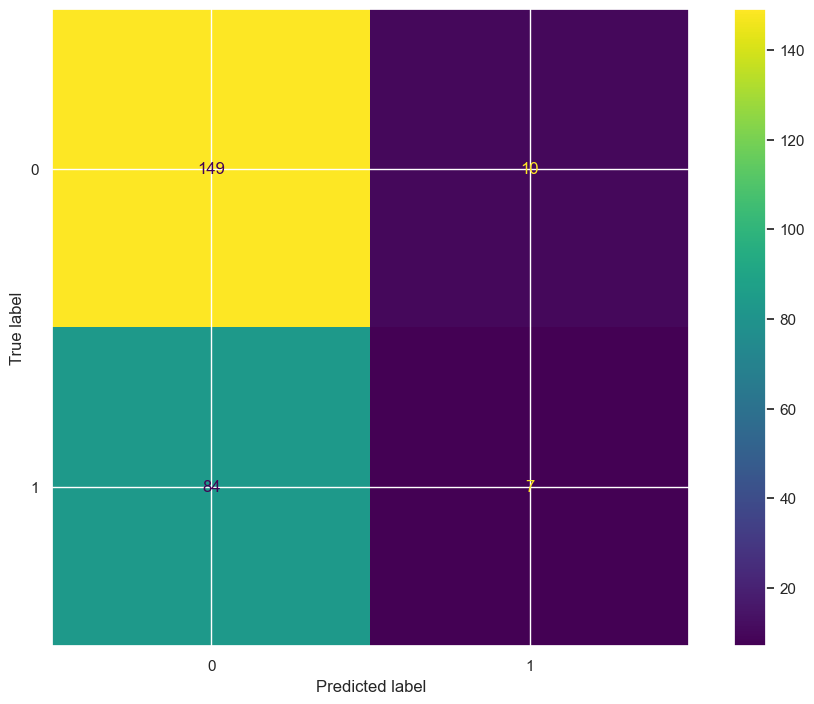

In [33]:
# plotting the confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test_raw, y_pred)


#### Ngram Models


In [34]:
import nltk

nltk_tokens = nltk.word_tokenize(preprocessed_text)
print("          ")
print(list(nltk.bigrams(nltk_tokens)))
print("          ")
print(list(nltk.trigrams(nltk_tokens)))


          
[('a', 'night'), ('night', 'valid'), ('valid', 'ceremoni'), ('ceremoni', 'celebr'), ('celebr', 'bad'), ('bad', 'great'), ('great', 'georg'), ('georg', 'blaha'), ('blaha', 'lou'), ('lou', 'imag'), ('imag', 'when'), ('when', 'think'), ('think', 'peopl'), ('peopl', 'play'), ('play', 'piston'), ('piston', 'year'), ('year', 'sinc'), ('sinc', 'around'), ('around', 'detroit'), ('detroit', 'realiz'), ('realiz', 'seven'), ('seven', 'men'), ('men', 'honor'), ('honor', 'name'), ('name', 'hang'), ('hang', 'court'), ('court', 'the'), ('the', 'palac'), ('palac', 'five'), ('five', 'direct'), ('direct', 'involv'), ('involv', 'bad'), ('bad', 'boy'), ('boy', 'realiz'), ('realiz', 'special'), ('special', 'group'), ('group', 'denni'), ('denni', 'rodman'), ('rodman', 'make'), ('make', 'eight'), ('eight', 'friday'), ('friday', 'night'), ('night', 'six'), ('six', 'either'), ('either', 'play'), ('play', 'coach'), ('coach', 'built'), ('built', 'bad'), ('bad', 'boy'), ('boy', 'talk'), ('talk', 'jack'

In [35]:
# Finding the Tf Idf

vectorier = TfidfVectorizer(min_df=5, max_features=5000, ngram_range=(1, 1))
X_train_tfidf = vectorier.fit_transform(X_train)


In [36]:
x_test_tfidf = vectorier.transform(X_test)


#### Logisric Regression with GridSearch cv

#### Used Tfidf inputs


In [37]:
# performing ML models with tf idf data
# The Logistic Regression
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

kf = StratifiedKFold(n_splits=5, random_state=13, shuffle=True)
lr = LogisticRegression(random_state=13)

param_grid = {'penalty': ['l1', 'l2'], 'C': [
    0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 20, 100, 1000]}
clf = GridSearchCV(estimator=lr, cv=kf,
                   param_grid=param_grid, scoring='roc_auc')
clf.fit(X_train_tfidf, y_train_raw)

print('Best score: {}'.format(clf.best_score_))
print('Best params: {}'.format(clf.best_params_))


Best score: 0.8078880471380471
Best params: {'C': 1, 'penalty': 'l2'}


In [38]:
lr = LogisticRegression(random_state=13, C=1, penalty='l2')
lr.fit(X_train_tfidf, y_train_raw)


LogisticRegression(C=1, random_state=13)

In [39]:
roc_auc_score(y_train_raw, lr.predict_proba(X_train_tfidf)[:, 1])


0.9670842789670613

#### Random Forest Classifier Text Classification


In [40]:
# random  forest classifier
from sklearn.ensemble import RandomForestClassifier

random_fores = RandomForestClassifier(random_state=13, verbose=1)

param_grid = {'n_estimators': [200, 500, 1000], 'max_features': [
    'auto', 'log2'], 'max_depth': [4, 5, 6, 7, 8], 'criterion': ['gini', 'entropy']}

clf = GridSearchCV(estimator=random_fores, cv=kf,
                   param_grid=param_grid, scoring='roc_auc', verbose=1)

clf.fit(X_train_tfidf, y_train_raw)

print('Best score: {}'.format(clf.best_score_))
print('Best params: {}'.format(clf.best_params_))


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

Best score: 0.8375917360741921
Best params: {'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 1000}


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    5.7s finished


### Designing a Pipline For Text Classification


In [47]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
import xgboost as xgb

pipe = Pipeline([('tfid', TfidfTransformer()),
                 ('model', MultinomialNB()),
                 ('model', xgb.XGBClassifier(
                     learning_rate=0.1,
                     max_depth=7,
                     n_estimators=80,
                     use_label_encoder=False,
                     eval_metric='auc',
                     # colsample_bytree=0.8,
                     # subsample=0.7,
                     # min_child_weight=5,
                 ))])


In [49]:
from sklearn import metrics
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    accuracy_score
)

pipe.fit(Padded_X_train, y_train_raw)
y_pred_class = pipe.predict(Padded_X_test)
print(metrics.accuracy_score(y_test_raw, y_pred_class))


0.612
